# Importing Data

In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time
from tensorflow import keras as keras
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [306]:
stock = 'aapl' # Apple

df = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
print(df.shape)
df.head()

(8364, 6)


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


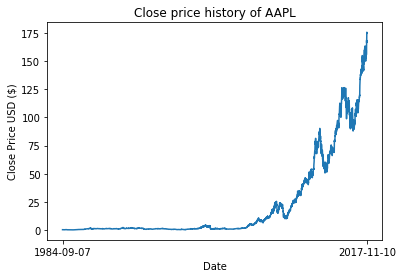

In [307]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

# Functions

In [308]:
# x has shape (num_samples, timestep)
def prepare_autoreg(data, timestep, offset):
    x,y = [],[]
    for i in range(timestep,len(data)):
        if i+offset-1 < len(data):
            x.append(data[i-timestep:i])
            y.append(data[i+offset-1])
        else:
            break
    return np.array(x), np.array(y)

In [309]:
def train_val_test_split(data, timestep, split=[0.6,0.2], offset=1, scaled=False, stationary=False):
    
    # Split train, validation & test data
    length = len(data)+1 if stationary else len(data)
    train_split = int(length * split[0]) + (-1 if stationary else 0)
    val_split = int(length * (split[0]+split[1])) + (-1 if stationary else 0)
    train_data = data[ : train_split] 
    val_data = data[train_split-timestep-offset+1 : val_split] 
    test_data = data[val_split-timestep-offset+1 : ]

    # Normalization if needed
    scaler = None
    if scaled:  
        scaler = MinMaxScaler(feature_range=(0,1))
        train_data = scaler.fit_transform(np.array(train_data).reshape(-1,1))
        val_data = scaler.transform(np.array(val_data).reshape(-1,1))
        test_data = scaler.transform(np.array(test_data).reshape(-1,1))
        
    # Generate training and test dataset
    xtr, ytr = prepare_autoreg(train_data, timestep, offset)
    xval, yval = prepare_autoreg(val_data, timestep, offset)
    xts, yts = prepare_autoreg(test_data, timestep, offset)

    return (xtr, ytr, xval, yval, xts, yts), scaler

In [310]:
def build_lstm(timestep, nodes):
    lstm = Sequential()
    lstm.add(LSTM(nodes, return_sequences=True, input_shape=(timestep,1)))
    lstm.add(LSTM(nodes))
    lstm.add(Dense(nodes))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm

In [311]:
def evaluate_lstm(data, model, scaler, **kwargs):
    
    # Define variables from arguments
    (xtr, ytr, xval, yval, xts, yts) = data
    show_loss = kwargs['show_loss'] if 'show_loss' in kwargs else 1 # show loss over epochs plot
    show_plot = kwargs['show_plot'] if 'show_plot' in kwargs else 1 # show time series plot
    stationary = kwargs['stationary'] if 'stationary' in kwargs else False # not stationary data by default
    
    # Check for missing args
    check_args = [k for k in ['actual_data','timestep','offset'] if k not in kwargs]
    if (show_plot or stationary) and len(check_args):
        raise Exception('The followings arguments are missing: %s' % ', '.join(check_args))
        return
    if show_loss and 'hist' not in kwargs:
        raise Exception('Please provide the model history handle (hist=handle) for plotting loss.')
        return
        
    # Prediction
    ytr_pred = model.predict(xtr)
    yval_pred = model.predict(xval)
    yts_pred = model.predict(xts)

    # Inverse transform all y values
    ytr_pred_itf = np.ravel(scaler.inverse_transform(ytr_pred))
    yval_pred_itf = np.ravel(scaler.inverse_transform(yval_pred))
    yts_pred_itf = np.ravel(scaler.inverse_transform(yts_pred))
    ytr_true = np.ravel(scaler.inverse_transform(ytr))
    yval_true = np.ravel(scaler.inverse_transform(yval))
    yts_true = np.ravel(scaler.inverse_transform(yts))
    
    # For stationary data, perform necessary inverse transformation
    if stationary:
        actual_data, timestep, offset = kwargs['actual_data'], kwargs['timestep'], kwargs['offset']
        str_end = timestep+offset-2 + len(ytr_pred_itf) + 1
        sval_end = str_end + len(yval_pred_itf)
        true_data = actual_data['Close'].values
        ytr_pred_itf = true_data[timestep+offset-2 : str_end] + np.r_[0,ytr_pred_itf]
        yval_pred_itf = true_data[str_end : sval_end] + yval_pred_itf
        yts_pred_itf = true_data[sval_end : -1] + yts_pred_itf
        ytr_true = true_data[timestep+offset-2 : str_end] + np.r_[0,ytr_true]
        yval_true = true_data[str_end : sval_end] + yval_true
        yts_true = true_data[sval_end : -1] + yts_true

    # Get RMSE
    rmse_tr = mean_squared_error(ytr_true, ytr_pred_itf, squared=False)
    rmse_val = mean_squared_error(yval_true, yval_pred_itf, squared=False)
    rmse_ts = mean_squared_error(yts_true, yts_pred_itf, squared=False)

    # Visualize loss
    if show_loss:
        hist = kwargs['hist']
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training', 'Validation'])
        plt.xlabel('Epochs')
        plt.title('Loss (MSE) over Epochs')
        plt.show()
        print('RMSE (Train):', rmse_tr)
        print('RMSE (Val):', rmse_val)

    # Visualize data
    if show_plot:
        # Define variables
        actual_data, timestep, offset = kwargs['actual_data'], kwargs['timestep'], kwargs['offset']
        title = kwargs['title'] if 'title' in kwargs else 'Predicted Close Values'
        suffix = ' (%s)' % kwargs['stock'].upper() if 'stock' in kwargs else ''
        
        # Define params
        dates = actual_data.index.values
        ytr_end = ytr_pred_itf.shape[0] + timestep + offset-1
        yval_end = yval_pred_itf.shape[0] + ytr_end
    
        # Plot
        plt.figure(figsize=(8,5))
        plt.plot(actual_data['Close'], label='Actual')
        plt.plot(dates[timestep+offset-1:ytr_end], ytr_pred_itf, label='Pred (Train)\nRMSE = %.3f' % rmse_tr)
        plt.plot(dates[ytr_end:yval_end], yval_pred_itf, label='Pred (Val)\nRMSE = %.3f' % rmse_val)
        plt.plot(dates[yval_end:], yts_pred_itf, label='Pred (Test)\nRMSE = %.3f' % rmse_ts)
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.xticks([list(dates)[0], list(dates)[-1]])
        plt.title(title + suffix)
        plt.legend()
        plt.show()
        
    return (rmse_tr, rmse_val, rmse_ts), (ytr_pred_itf, yval_pred_itf, yts_pred_itf)

In [312]:
def classify(x, y):
    diff = np.ravel(y) - np.ravel(x[:,-1]) # t+? - t
    return np.where(diff >= 0, 1, 0).reshape(-1).tolist()

# Regression Models for Diff Time Periods

## Defining Tuned Hyperparameters

In [313]:
step = 55
node = 45
epoch = 40
bsize = 32
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5) # global callback for all models
stock_data = df['Close'].values # create new df with only 'Close' column

## Next Day Prediction

In [314]:
# Generate train/val/test split
data_dd, scaler_dd = train_val_test_split(stock_data, step, split=[0.8,0.1], offset=1, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = data_dd
print(xtr.shape, ytr.shape)
print(xval.shape, yval.shape)
print(xts.shape, yts.shape)

# Build LSTM model
lstm_dd = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_dd = lstm_dd.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

(6636, 55, 1) (6636, 1)
(836, 55, 1) (836, 1)
(837, 55, 1) (837, 1)
Training... Done. Time taken: 37.211s


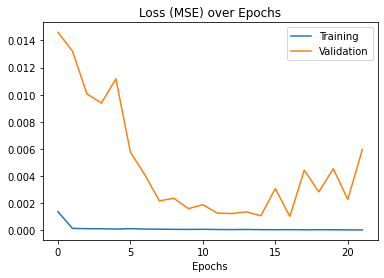

RMSE (Train): 0.4254377881387586
RMSE (Val): 3.5705143493302898


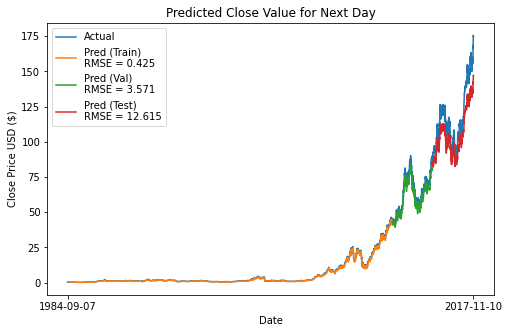

In [315]:
rmse_dd, pred_dd = evaluate_lstm(data_dd, lstm_dd, scaler_dd,
                                 hist=hist_dd, title='Predicted Close Value for Next Day',
                                 actual_data=df, timestep=step, offset=1);

## Next Week Prediction

In [316]:
# Generate train/val/test split
data_wk, scaler_wk = train_val_test_split(stock_data, step, split=[0.8,0.1], offset=5, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = data_wk

# Build LSTM model
lstm_wk = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_wk = lstm_wk.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 31.242s


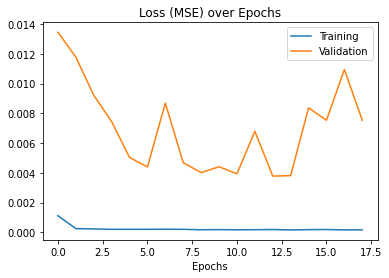

RMSE (Train): 0.5762206940823813
RMSE (Val): 4.014081881215224


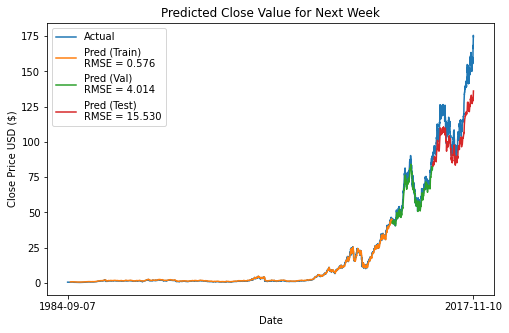

In [317]:
rmse_wk, pred_wk = evaluate_lstm(data_wk, lstm_wk, scaler_wk, 
                                 hist=hist_wk, title='Predicted Close Value for Next Week',
                                 actual_data=df, timestep=step, offset=5);

## Next Month Prediction

In [318]:
# Generate train/val/test split
data_mm, scaler_mm = train_val_test_split(stock_data, step, split=[0.8,0.1], offset=30, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = data_mm

# Build LSTM model
lstm_mm = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
hist_mm = lstm_mm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 30.917s


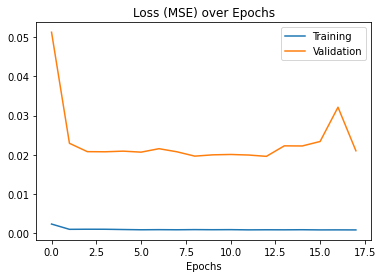

RMSE (Train): 1.4511015821660576
RMSE (Val): 6.707377501623363


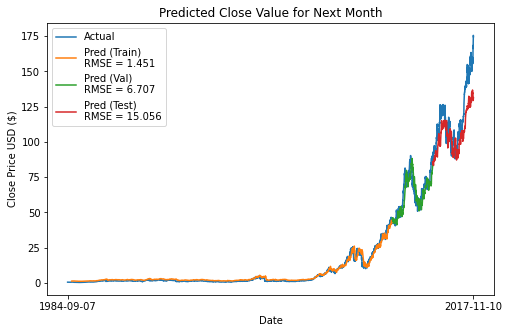

In [319]:
rmse_mm, pred_mm = evaluate_lstm(data_mm, lstm_mm, scaler_mm,
                                 hist=hist_mm, title='Predicted Close Value for Next Month',
                                 actual_data=df, timestep=step, offset=30);

## Comparison

In [320]:
compare_df_dict = {
    'Offset': ['t+1', 't+5', 't+30'],
    'RMSE (Train)': [rmse_dd[0], rmse_wk[0], rmse_mm[0]],
    'RMSE (Val)': [rmse_dd[1], rmse_wk[1], rmse_mm[1]],
    'RMSE (Test)': [rmse_dd[2], rmse_wk[2], rmse_mm[2]]
}
compare_df = pd.DataFrame(compare_df_dict)
compare_df.set_index('Offset', inplace=True)
display(compare_df)

,RMSE (Train),RMSE (Val),RMSE (Test)
Offset,,,
t+1,0.425438,3.570514,12.615179
t+5,0.576221,4.014082,15.529867
t+30,1.451102,6.707378,15.056094


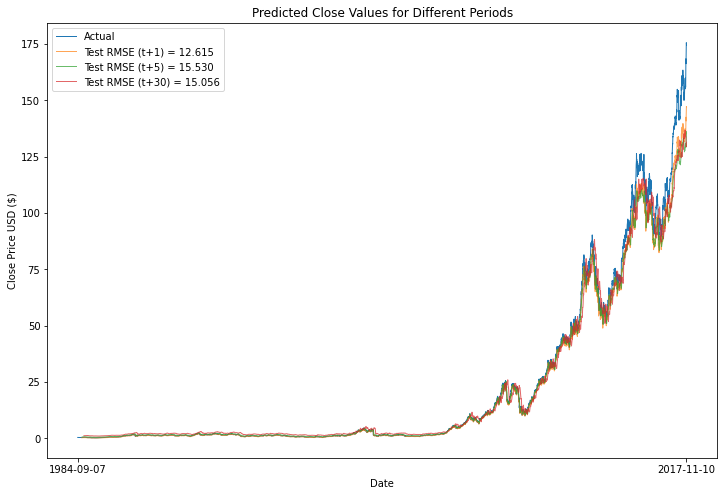

In [321]:
plt.figure(figsize=(12,8))
plt.plot(df['Close'], linewidth=1, label='Actual')
plt.plot(df.index.values[step:], np.r_[pred_dd[0],pred_dd[1],pred_dd[2]], linewidth=1, alpha=0.7, label='Test RMSE (t+1) = %.3f' % rmse_dd[2])
plt.plot(df.index.values[step+4:], np.r_[pred_wk[0],pred_wk[1],pred_wk[2]], linewidth=1, alpha=0.7, label='Test RMSE (t+5) = %.3f' % rmse_wk[2])
plt.plot(df.index.values[step+29:], np.r_[pred_mm[0],pred_mm[1],pred_mm[2]], linewidth=1, alpha=0.7, label='Test RMSE (t+30) = %.3f' % rmse_mm[2])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.title('Predicted Close Values for Different Periods')
plt.legend()
plt.show()

# Regression Model for Diff Time Periods (Stationary)

In [322]:
stationary_data = (df['Close'].values)[1:] - (df['Close'].values)[:-1] # remove seasonality

## Next Day Prediction (Stationary)

In [323]:
# Generate train/val/test split
sdata_dd, sscaler_dd = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=1, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_dd
print(xtr.shape, ytr.shape)
print(xval.shape, yval.shape)
print(xts.shape, yts.shape)

# Build LSTM model
slstm_dd = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
shist_dd = slstm_dd.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

(4962, 55, 1) (4962, 1)
(1673, 55, 1) (1673, 1)
(1673, 55, 1) (1673, 1)
Training... Done. Time taken: 55.821s


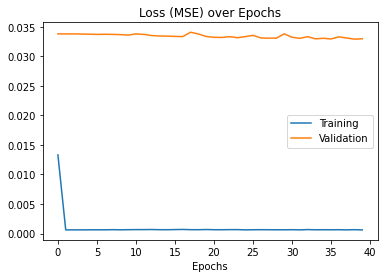

RMSE (Train): 0.05485511389770236
RMSE (Val): 0.4137696715364064


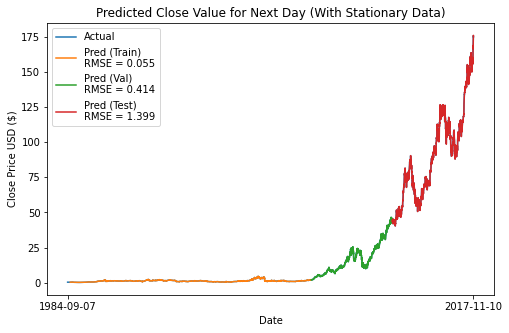

In [324]:
srmse_dd, spred_dd = evaluate_lstm(sdata_dd, slstm_dd, sscaler_dd, stationary=True,
                                   hist=shist_dd, title='Predicted Close Value for Next Day (With Stationary Data)',
                                   actual_data=df, timestep=step, offset=1);

## Next Week Prediction (Stationary)

In [325]:
# Generate train/val/test split
sdata_wk, sscaler_wk = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=5, scaled=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_wk

# Build LSTM model
slstm_wk = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
shist_wk = slstm_wk.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 54.392s


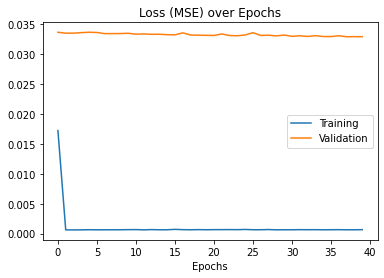

RMSE (Train): 0.06403880519482315
RMSE (Val): 0.4135197024679638


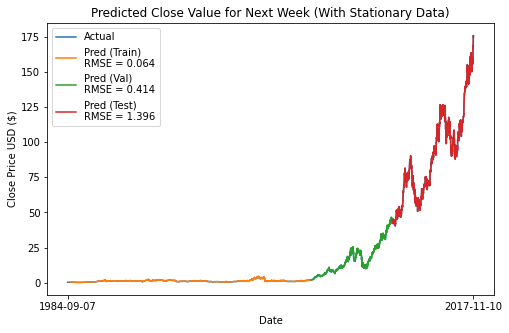

In [326]:
srmse_wk, spred_wk = evaluate_lstm(sdata_wk, slstm_wk, sscaler_wk, stationary=True,
                                  hist=shist_wk, title='Predicted Close Value for Next Week (With Stationary Data)',
                                  actual_data=df, timestep=step, offset=5);

## Next Month Prediction (Stationary)

In [327]:
# Generate train/val/test split
sdata_mm, sscaler_mm = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=30, scaled=True, stationary=True)
(xtr, ytr, xval, yval, xts, yts) = sdata_mm

# Build LSTM model
slstm_mm = build_lstm(timestep=step, nodes=node)

# Train the model
start = time.time()
print('Training...', end=' ')
shist_mm = slstm_mm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

Training... Done. Time taken: 33.611s


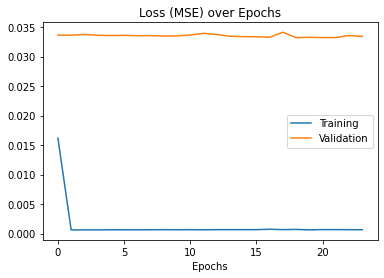

RMSE (Train): 0.05963425671545717
RMSE (Val): 0.41643750364385945


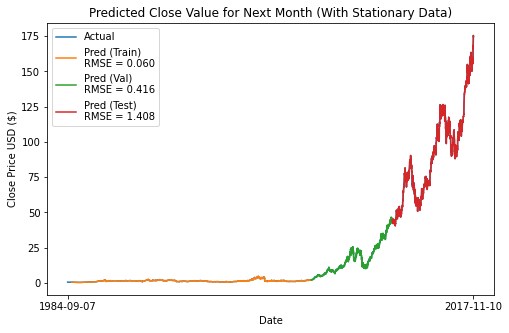

In [328]:
srmse_mm, spred_mm = evaluate_lstm(sdata_mm, slstm_mm, sscaler_mm, stationary=True,
                                   hist=shist_mm, title='Predicted Close Value for Next Month (With Stationary Data)',
                                   actual_data=df, timestep=step, offset=30);

## Comparison (With Models trained on Stationary Data)

In [329]:
compare_df['RMSE (Train/Stat)'] = [srmse_dd[0], srmse_wk[0], srmse_mm[0]]
compare_df['RMSE (Val/Stat)'] = [srmse_dd[1], srmse_wk[1], srmse_mm[1]]
compare_df['RMSE (Test/Stat)'] = [srmse_dd[2], srmse_wk[2], srmse_mm[2]]
display(compare_df)

,RMSE (Train),RMSE (Val),RMSE (Test),RMSE (Train/Stat),RMSE (Val/Stat),RMSE (Test/Stat)
Offset,,,,,,
t+1,0.425438,3.570514,12.615179,0.054855,0.413770,1.399431
t+5,0.576221,4.014082,15.529867,0.064039,0.413520,1.396125
t+30,1.451102,6.707378,15.056094,0.059634,0.416438,1.407623


# Prediction of Trend

In [330]:
datas_trend = [data_dd, data_wk, data_mm]
scalers_trend = [scaler_dd, scaler_wk, scaler_mm]
preds_trend = [pred_dd, pred_wk, pred_mm, spred_dd, spred_wk, spred_mm]
for offset in [1,5,30]:
    data, scaler = train_val_test_split(stock_data, step, split=[0.6,0.2], offset=offset, scaled=True)
    datas_trend.append(data)
    scalers_trend.append(scaler)

In [331]:
trend_true, trend_pred = [[] for k in range(6)], [[] for k in range(6)]
for i in range(6): # ×6 for dd,wk,mm for normal and stationary data
    for j in range(3): # ×3 for train, val, test
        data, scaler, pred =  datas_trend[i], scalers_trend[i], preds_trend[i]
        trend_true[i] += classify(data[j*2], data[j*2+1])
        trend_pred[i] += classify(data[j*2], scaler.transform(pred[j].reshape(-1,1)))
    
metrics_dict = {
    'Accuracy':[],
    'Precision':[],
    'Recall':[],
    'F1 Score':[]
} 

print('Confusion Matrices for each Model:')
for i in range(6):
    metrics_dict['Accuracy'].append(accuracy_score(trend_true[i], trend_pred[i]))
    metrics_dict['Precision'].append(precision_score(trend_true[i], trend_pred[i]))
    metrics_dict['Recall'].append(recall_score(trend_true[i], trend_pred[i]))
    metrics_dict['F1 Score'].append(f1_score(trend_true[i], trend_pred[i]))
    tn, fp, fn, tp = confusion_matrix(trend_true[i], trend_pred[i]).ravel()
    cmat = pd.DataFrame({'':['Pred Up','Pred Down'], 'Actual Up':[tp,fn], 'Actual Down':[fp,tn]})
    cmat.set_index('', inplace=True)
    print(['Day:','\nWeek:','\nMonth:', 'Day (Stat):','\nWeek (Stat):','\nMonth (Stat):'][i])
    display(cmat)

Confusion Matrices for each Model:
Day:


,Actual Up,Actual Down
,,
Pred Up,19,9
Pred Down,4403,3878



Week:


,Actual Up,Actual Down
,,
Pred Up,3082,2691
Pred Down,1461,1071



Month:


,Actual Up,Actual Down
,,
Pred Up,3925,2703
Pred Down,1005,647


Day (Stat):


,Actual Up,Actual Down
,,
Pred Up,3049,2672
Pred Down,1373,1215



Week (Stat):


,Actual Up,Actual Down
,,
Pred Up,4266,1414
Pred Down,277,2348



Month (Stat):


,Actual Up,Actual Down
,,
Pred Up,4529,105
Pred Down,401,3245


In [332]:
metric_df = pd.DataFrame({k:v[:3] for k,v in metrics_dict.items()})
metric_df['Offset'] = compare_df.index.values
metric_df.set_index('Offset', inplace=True)
for metric in metrics_dict:
    metric_df[metric+' (Stat)'] = metrics_dict[metric][3:]
display(compare_df)
display(metric_df)

,RMSE (Train),RMSE (Val),RMSE (Test),RMSE (Train/Stat),RMSE (Val/Stat),RMSE (Test/Stat)
Offset,,,,,,
t+1,0.425438,3.570514,12.615179,0.054855,0.413770,1.399431
t+5,0.576221,4.014082,15.529867,0.064039,0.413520,1.396125
t+30,1.451102,6.707378,15.056094,0.059634,0.416438,1.407623


,Accuracy,Precision,Recall,F1 Score,Accuracy (Stat),Precision (Stat),Recall (Stat),F1 Score (Stat)
Offset,,,,,,,,
t+1,0.469010,0.678571,0.004297,0.008539,0.513178,0.532949,0.689507,0.601203
t+5,0.500060,0.533865,0.678406,0.597518,0.796388,0.751056,0.939027,0.834589
t+30,0.552174,0.592185,0.796146,0.679183,0.938889,0.977341,0.918661,0.947093


# Expected Gain

In [333]:
gains = [0 for k in range(6)]
num_trades = [0 for k in range(3)]
for i in range(6): # ×6 for dd,wk,mm for normal and stationary data
    for j in range(3): # ×3 for train, val, test
        data, scaler, pred =  datas_trend[i], scalers_trend[i], preds_trend[i]
        x,y = data[j*2], scaler.transform(pred[j].reshape(-1,1))
        diff = np.ravel(y) - np.ravel(x[:,-1])
        num_trades[i//2] = len(diff)
        gains[i] += diff @ classify(x,data[j*2+1])
         
for i in range(3):
    print('Total Expected Gain ' + ['(Day):','(Week):','(Month):'][i], end=' ')
    print('%.2f, %.2f (Stationary)' % (gains[i], gains[i+3]))
    
print()    
for i in range(3):
    print('Expected Gain per ' + ['Day:','Week:','Month:'][i], end=' ')
    print('%.2f, %.2f (Stationary)' % (gains[i]/num_trades[i], gains[i+3]/num_trades[i]))

Total Expected Gain (Day): -155.60, 3.13 (Stationary)
Total Expected Gain (Week): -147.55, 609.55 (Stationary)
Total Expected Gain (Month): -26.70, 2109.89 (Stationary)

Expected Gain per Day: -0.19, 0.00 (Stationary)
Expected Gain per Week: -0.09, 0.36 (Stationary)
Expected Gain per Month: -0.02, 1.26 (Stationary)


# Different Stocks

In [334]:
# up_stocks = ['aapl','ibm'] # upward trends
# both_stocks = ['xhr','mik'] # bi-directional trends
# down_stocks = ['sypr','ypf'] # downward trends
up_stocks, both_stocks, down_stocks = ['aapl'], ['mik'], ['ypf']
diff_stocks = {'vars':{},'model':{},'rmse':{},'acc':{},'rec':{},'prc':{},'f1':{},'gain':{}}

In [335]:
for stock in up_stocks+both_stocks+down_stocks:
    
    # Import stock data
    df = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
    stock_data = df['Close'].values
    stationary_data = (df['Close'].values)[1:] - (df['Close'].values)[:-1] # remove seasonality
    
    # Generate dataset
    data, scaler = train_val_test_split(stock_data, step, split=[0.6,0.2], offset=30, scaled=True)
    sdata, sscaler = train_val_test_split(stationary_data, step, split=[0.6,0.2], offset=30, scaled=True, stationary=True)
    (xtr, ytr, xval, yval, xts, yts) = sdata
    
    # Training, prediction, evaluation
    lstm = build_lstm(timestep=step, nodes=node)
    start = time.time()
    print('Training (%s)...' % stock, end=' ')
    lstm.fit(xtr, ytr, batch_size=bsize, epochs=epoch, validation_data=(xval, yval), callbacks=[callback], verbose=False)
    end = time.time()
    print('Done. Time taken: %.3fs' % (end-start))
    
    diff_stocks['vars'][stock] = (df, data, scaler, sdata, sscaler)
    diff_stocks['model'][stock] = lstm

Training (aapl)... Done. Time taken: 35.010s
Training (mik)... Done. Time taken: 3.758s
Training (ypf)... Done. Time taken: 16.743s


In [336]:
def evaluate_diff_stocks(stocks):
    for stock in stocks:
        df = diff_stocks['vars'][stock][0]
        data, scaler = diff_stocks['vars'][stock][1], diff_stocks['vars'][stock][2]
        sdata, sscaler = diff_stocks['vars'][stock][3], diff_stocks['vars'][stock][4]
        model = diff_stocks['model'][stock]
        
        # Get RMSE and Predicted Values
        rmse, pred = evaluate_lstm(sdata, model, sscaler, stationary=True,
                                   show_loss=0, title='Predicted Close Values for Next Month',
                                   actual_data=df, timestep=step, offset=30, stock=stock);
        
        # Find Accuracy, Precision, Recall, F1, Expected Gain
        trend_true, trend_pred = [], []
        gain = 0
        for i in range(3): # ×3 for train, val, test
            x,y = data[i*2], scaler.transform(pred[i].reshape(-1,1))
            diff = np.ravel(y) - np.ravel(x[:,-1])
            num_trades = len(diff)
            gain += diff @ classify(x,data[i*2+1])
            trend_true += classify(x, data[i*2+1])
            trend_pred += classify(x,y)
        gain = gain/num_trades

        # Store Metrics
        diff_stocks['rmse'][stock] = [v for v in rmse]
        diff_stocks['acc'][stock] = accuracy_score(trend_true, trend_pred)
        diff_stocks['prc'][stock] = precision_score(trend_true, trend_pred)
        diff_stocks['rec'][stock] = recall_score(trend_true, trend_pred)
        diff_stocks['f1'][stock] = f1_score(trend_true, trend_pred)
        diff_stocks['gain'][stock] = gain

INCREASING


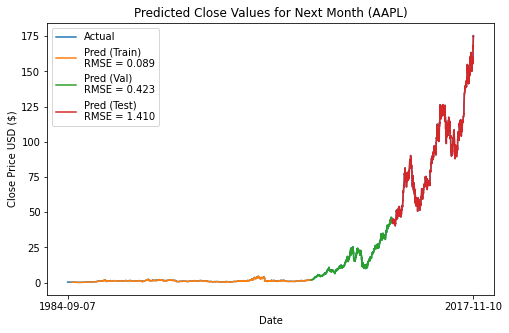

In [337]:
print('INCREASING')
evaluate_diff_stocks(up_stocks)

UP & DOWN


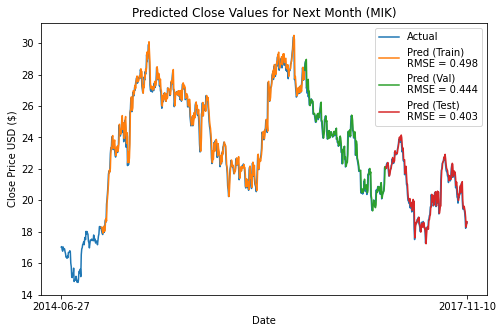

In [338]:
print('UP & DOWN')
evaluate_diff_stocks(both_stocks)

DOWN


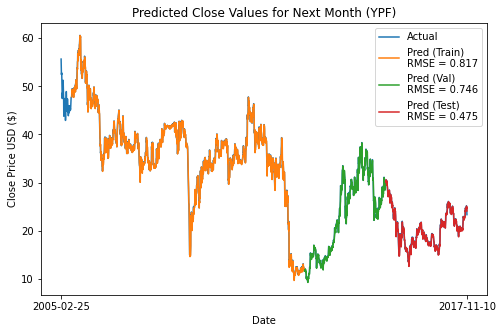

In [339]:
print('DOWN')
evaluate_diff_stocks(down_stocks)

In [340]:
print('Compare metrics for different stocks:')
compare_diff_stocks_dict = {
    'Stock': diff_stocks['model'].keys(),
    'RMSE (Train)': np.array(list(diff_stocks['rmse'].values()))[:,0],
    'RMSE (Val)': np.array(list(diff_stocks['rmse'].values()))[:,1],
    'RMSE (Test)': np.array(list(diff_stocks['rmse'].values()))[:,2],
    'Accuracy': diff_stocks['acc'].values(),
    'Precision': diff_stocks['prc'].values(),
    'Recall': diff_stocks['rec'].values(),
    'F1 Score': diff_stocks['f1'].values(),
    'Expected Gain (per month)': diff_stocks['gain'].values()
}
compare_diff_stocks_df = pd.DataFrame(compare_diff_stocks_dict)
compare_diff_stocks_df.set_index('Stock', inplace=True)
display(compare_diff_stocks_df)

Compare metrics for different stocks:


,RMSE (Train),RMSE (Val),RMSE (Test),Accuracy,Precision,Recall,F1 Score,Expected Gain (per month)
Stock,,,,,,,,
aapl,0.089034,0.423450,1.410468,0.875604,0.986527,0.802028,0.884762,1.229516
mik,0.497881,0.444496,0.402591,0.947917,0.943020,0.943020,0.943020,0.284852
ypf,0.817483,0.745681,0.475229,0.942234,0.954117,0.934154,0.944030,0.127400
